In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from src.preprocessing_pipeline import build_preprocessed_data

In [3]:
data = build_preprocessed_data()

Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.


In [4]:
X_train_cont_std = data["X_train_cont_std"]
X_val_cont_std = data["X_val_cont_std"]
X_test_cont_std = data["X_test_cont_std"]

Y_train = data["Y_train"]
Y_val = data["Y_val"]
Y_test = data["Y_test"]

cols_continuous = data["cols_continuous"]

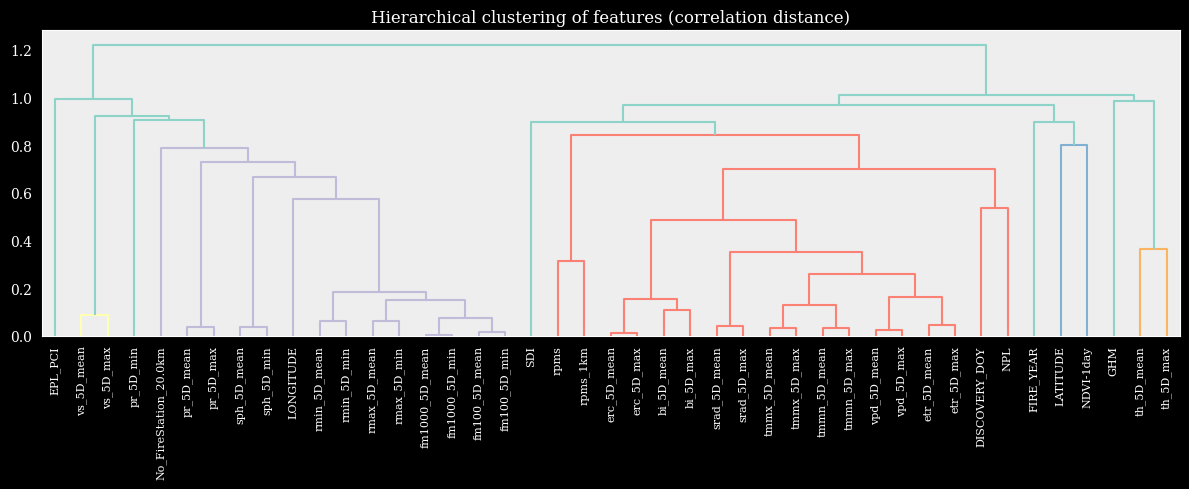

In [6]:
plt.style.use('dark_background')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['patch.facecolor'] = '302a27'
plt.rcParams['patch.edgecolor'] = 'eeeeee'
plt.rcParams['axes.facecolor'] = 'eeeeee'
plt.rcParams['axes.grid'] = False
plt.rcParams['text.color'] = 'white'

# Correlation distance between features
X_cont_df = pd.DataFrame(X_train_cont_std, columns=cols_continuous)
corr = X_cont_df.corr()
dist = 1 - corr  # correlation distance
dist_condensed = squareform(dist.values, checks=False)

Z = linkage(dist_condensed, method='average')  # or 'ward', 'complete', etc.

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=corr.columns, leaf_rotation=90)
plt.title("Hierarchical clustering of features (correlation distance)")
plt.tight_layout()
plt.show()


In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Try a few cluster numbers
for k in [2, 3, 4, 5, 6]:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='euclidean',
        linkage='ward'
    )
    labels = model.fit_predict(X_train_cont_std)
    score = silhouette_score(X_train_cont_std, labels)
    print(f"k={k}, silhouette={score:.3f}")


k=2, silhouette=0.269
k=3, silhouette=0.258
k=4, silhouette=0.140
k=5, silhouette=0.120
k=6, silhouette=0.125


In [8]:
k = 3  # chosen based on silhouette - the biggest drop is between 2 and 3 clusters
cluster_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
cluster_labels = cluster_model.fit_predict(X_train_cont_std)

cluster_df = pd.DataFrame({
    "cluster": cluster_labels,
    "fire_size_label": np.asarray(Y_train)
})
pd.crosstab(cluster_df["cluster"], cluster_df["fire_size_label"])


fire_size_label,0,1,2,3
cluster,,,,
0,177,276,508,575
1,294,252,68,16
2,135,63,19,17


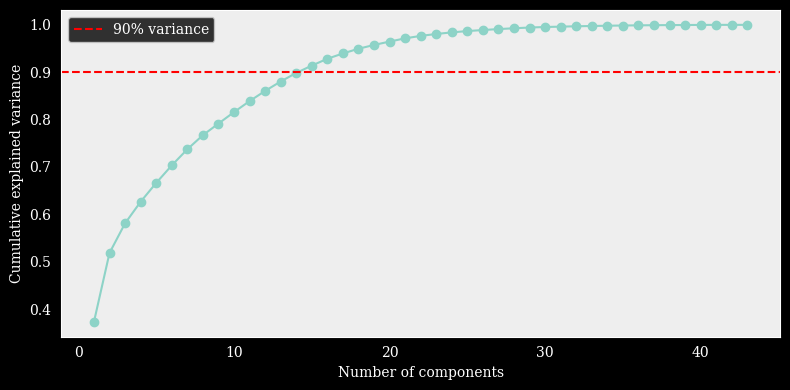

In [18]:
from sklearn.decomposition import PCA

pca = PCA()  # full PCA
X_pca = pca.fit_transform(X_train_cont_std)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained) + 1), cum_explained, marker='o')
plt.axhline(0.9, color='red', linestyle='--', label='90% variance')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.legend()
plt.legend().get_frame().set_facecolor('black')

plt.tight_layout()
plt.show()


In [20]:
k = 13  # for example, based on the plot. This is probably why cluster analysis was not that useful, since there are many Principal Components needed to explain 90% of the variance.
pca_k = PCA(n_components=k)
X_pca_k = pca_k.fit_transform(X_train_cont_std)

pc_loadings = pd.DataFrame(
    pca_k.components_.T,
    columns=[f"PC{i + 1}" for i in range(k)],
    index=cols_continuous
)

# Top contributors to PC1
pc1_top = pc_loadings["PC1"].sort_values(key=abs, ascending=False).head(10)
pc1_top

erc_5D_mean      -0.237720
erc_5D_max       -0.237120
fm100_5D_mean     0.234001
fm1000_5D_min     0.232954
fm1000_5D_mean    0.232875
fm100_5D_min      0.230086
vpd_5D_mean      -0.224700
vpd_5D_max       -0.223184
etr_5D_mean      -0.219009
rmin_5D_mean      0.214790
Name: PC1, dtype: float64

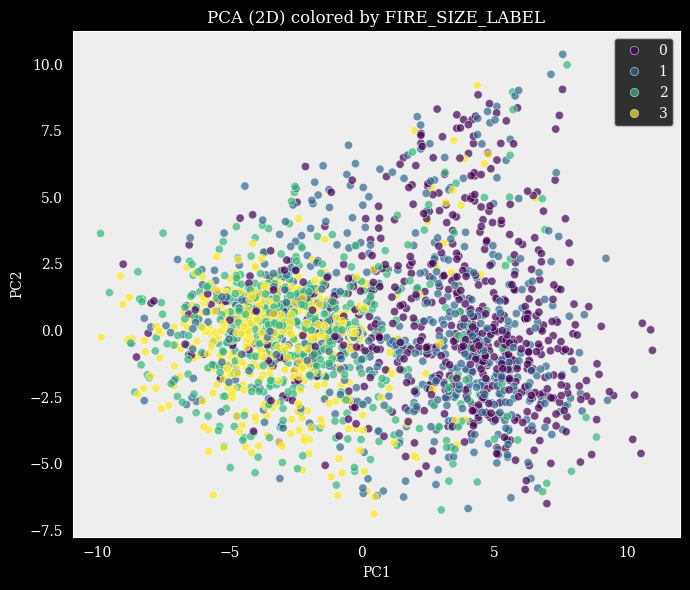

In [22]:
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_train_cont_std)

pca_df = pd.DataFrame({
    "PC1": X_pca_2[:, 0],
    "PC2": X_pca_2[:, 1],
    "fire_size_label": np.asarray(Y_train)
})

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="fire_size_label",
    palette="viridis",
    alpha=0.7
)
plt.title("PCA (2D) colored by FIRE_SIZE_LABEL")
plt.legend().get_frame().set_facecolor('black')
plt.tight_layout()
plt.show()


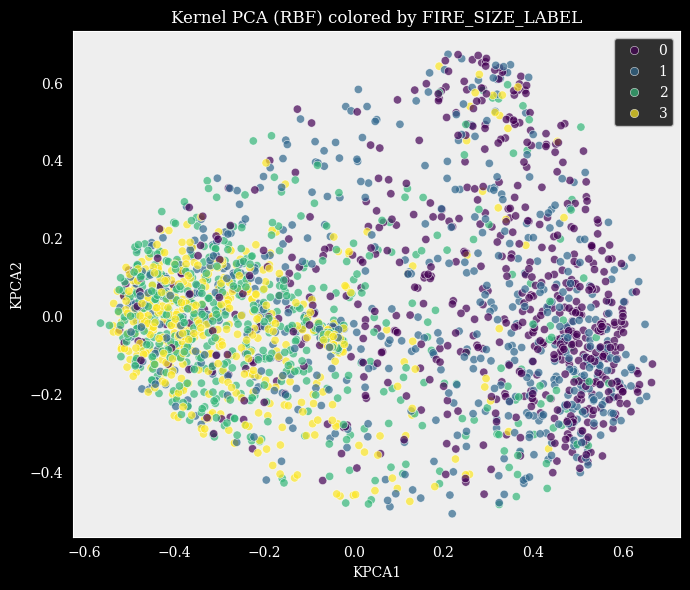

In [24]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=0.01,  # tune this
    random_state=207
)
X_kpca = kpca.fit_transform(X_train_cont_std)

kpca_df = pd.DataFrame({
    "KPCA1": X_kpca[:, 0],
    "KPCA2": X_kpca[:, 1],
    "fire_size_label": np.asarray(Y_train)
})

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=kpca_df,
    x="KPCA1",
    y="KPCA2",
    hue="fire_size_label",
    palette="viridis",
    alpha=0.7
)
plt.title("Kernel PCA (RBF) colored by FIRE_SIZE_LABEL")
plt.legend().get_frame().set_facecolor('black')
plt.tight_layout()
plt.show()


In [27]:
k = 3
model = AgglomerativeClustering(n_clusters=k, linkage='ward')
kpca_clusters = model.fit_predict(X_kpca)

pd.crosstab(kpca_clusters, Y_train)

col_0,0,1,2,3
row_0,,,,
0,92,205,450,543
1,356,279,89,34
2,158,107,56,31


It seems Kernel PCA is better than PCA for this dataset. For example, cluster 0, which is probably a Very Dangerous zone due to the large number of large fires it captures, would have some false positives, 92 small fires. However, with regular PCA, cluster 0 would have 177 small fires, a significantly higher number of false positives.